#### [PyTorch를 활용한 머신러닝, 딥러닝 철저 입문]
## [Chapter 6-5] 예제: 시계열데이터 - 이상기온 탐지

---

## \#0. Download Data

다음 주소에서 데이터를 다운로드 한다.

> http://data.kma.go.kr/stcs/grnd/grndTaList.do?pgmNo=70

- 데이터는 `2013/01/01 ~ 2018/12/31` 의 6년치 데이터를 사용하였다.

In [1]:
!tree ./data/seoul_temp

./data/seoul_temp
└── temp.csv

0 directories, 1 file


위와 같이 `seoul_temp` 디렉토리를 생성해서 csv 파일을 넣었다.

---

## \#1. Import Modules

In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np

import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

---

## \#2. Load Data

### 2-1. Get `csv` Data

In [3]:
pd.set_option('display.max_rows', 11)
data = pd.read_csv('./data/seoul_temp/temp.csv', skiprows=[0, 1, 2, 3, 4, 5], encoding='cp949')
print(data.shape)
data

(2191, 5)


,날짜,지점,평균기온(℃),최저기온(℃),최고기온(℃)
0,2013-01-01,108,-4.7,-8.7,0.0
1,2013-01-02,108,-11.7,-15.1,-4.8
2,2013-01-03,108,-13.2,-16.4,-9.3
3,2013-01-04,108,-10.7,-14.8,-5.8
4,2013-01-05,108,-7.0,-12.1,-1.2
...,...,...,...,...,...
2186,2018-12-27,108,-10.1,-12.5,-6.5
2187,2018-12-28,108,-10.5,-14.4,-6.6
2188,2018-12-29,108,-7.6,-10.5,-3.0
2189,2018-12-30,108,-6.8,-11.3,-0.9


### 2-2. Plotting

총 `2191일`의 데이터가 잘 들어있음을 확인할 수 있다. 이 중 **평균기온**을 활용하여 데이터 분석을 해 보자.

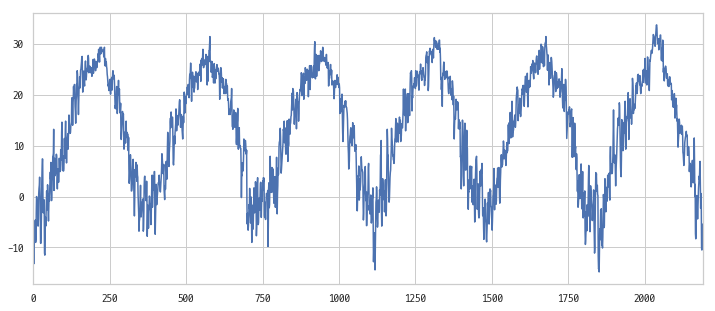

In [4]:
temp = data['평균기온(℃)']

plt.figure(figsize=(12, 5))
temp.plot()
plt.show()

총 6년의 데이터이므로, 6번의 주기를 확인할 수 있다.

---

## \#3. Training / Test Data

### 3-1. Split train / test dataz

training과 test data는 6년 중 앞의 4년과 뒤의 2년으로 분할한다.

- `2013/01/01 ~ 2016/12/31` 의 데이터

In [5]:
data[:1461]

,날짜,지점,평균기온(℃),최저기온(℃),최고기온(℃)
0,2013-01-01,108,-4.7,-8.7,0.0
1,2013-01-02,108,-11.7,-15.1,-4.8
2,2013-01-03,108,-13.2,-16.4,-9.3
3,2013-01-04,108,-10.7,-14.8,-5.8
4,2013-01-05,108,-7.0,-12.1,-1.2
...,...,...,...,...,...
1456,2016-12-27,108,-2.3,-6.3,1.3
1457,2016-12-28,108,-3.7,-8.4,2.6
1458,2016-12-29,108,-4.2,-7.2,-1.1
1459,2016-12-30,108,-3.9,-9.1,1.0


In [6]:
raw_train_X = np.array(temp[:1461])
len(raw_train_X)

1461

- `2017/01/01 ~ 2018/12/31` 의 데이터

In [7]:
data[1461:]

,날짜,지점,평균기온(℃),최저기온(℃),최고기온(℃)
1461,2017-01-01,108,2.7,-1.6,6.9
1462,2017-01-02,108,5.0,1.8,9.2
1463,2017-01-03,108,2.0,-2.3,7.7
1464,2017-01-04,108,3.9,1.0,8.9
1465,2017-01-05,108,3.8,-0.1,7.3
...,...,...,...,...,...
2186,2018-12-27,108,-10.1,-12.5,-6.5
2187,2018-12-28,108,-10.5,-14.4,-6.6
2188,2018-12-29,108,-7.6,-10.5,-3.0
2189,2018-12-30,108,-6.8,-11.3,-0.9


In [8]:
raw_test_X = np.array(temp[1461:])
len(raw_test_X)

730

- 개수 확인

In [10]:
len(raw_train_X) + len(raw_test_X)

2191

총 2191의 데이터가 잘 나뉘었음을 확인할 수 있다.

### 3-2. decompose Train data - Windowing

- 시계열 데이터를 학습시키는 데에 있어서 과적합을 일으킬 수 있는 노이즈의 영향을 최소화 할 필요가 있다.
- 이를 위해 **일정 길이를 갖는 window**를 생성해서 부분 연속열을 추출해 train data로 사용한다.

- window의 size는 6개월의 기간에 해당하는 180으로 설정한다.

In [11]:
window_size = 180

In [12]:
train_X = list()

for i in range(len(raw_train_X) - window_size):
    train_X.append(raw_train_X[i:i+window_size])
    
train_X = np.array(train_X)

In [13]:
print(pd.DataFrame(train_X).shape)
pd.DataFrame(train_X).head()

(1281, 180)


,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,-4.7,-11.7,-13.2,-10.7,-7.0,-6.3,-5.1,-4.6,-9.0,-8.3,...,25.8,26.6,25.1,22.9,23.5,25.1,24.5,25.1,25.5,27.2
1,-11.7,-13.2,-10.7,-7.0,-6.3,-5.1,-4.6,-9.0,-8.3,-3.2,...,26.6,25.1,22.9,23.5,25.1,24.5,25.1,25.5,27.2,27.7
2,-13.2,-10.7,-7.0,-6.3,-5.1,-4.6,-9.0,-8.3,-3.2,0.0,...,25.1,22.9,23.5,25.1,24.5,25.1,25.5,27.2,27.7,27.1
3,-10.7,-7.0,-6.3,-5.1,-4.6,-9.0,-8.3,-3.2,0.0,-0.5,...,22.9,23.5,25.1,24.5,25.1,25.5,27.2,27.7,27.1,24.3
4,-7.0,-6.3,-5.1,-4.6,-9.0,-8.3,-3.2,0.0,-0.5,-2.1,...,23.5,25.1,24.5,25.1,25.5,27.2,27.7,27.1,24.3,25.2


- 총 데이터는 **1281개**가 되었다 (= `len(raw_train_X) - window_size` = `1461 - 180`)


- 0 ~ 4 행의 데이터를 보면 한 칸씩 밀려나면서 데이터를 담고 있음을 확인할 수 있다.
- 각 행은 180개의 숫자 (=`window_size`) 로 이루어져 있다.

---

## \#4. Auto Encoder

- 시계열 데이터의 학습은 자기부호화기 (Auto Encoder) 를 이용한다.


- **`자기부호화기 Auto Encoder`** 란?
    - 입력으로 받는 데이터를 일정 크기까지 압축(축소)했다가 다시 복구하는 모델
    - 압축과 복구를 거치면서 다시 **원형의 데이터를 복구시킬 수 있는 파라미터를 찾는 것**이 목적이다.
    - 즉, 어떤 데이터가 들어왔을 때 그 원형의 데이터로 다시 복호화할 수 있는 모델이다.


- **`이상기온 탐지`**에서의 auto encoder의 쓰임
    - train data를 이용해 Auto Encoder 모델을 생성 (가중치 fitting)
    - test data를 입력받아 Auto Encoder의 output으로 나온 데이터와, test data의 원형 데이터를 비교해서 이상기온을 탐지할 수 있다.

### 4-1. Auto Encoder 

- 180개의 input을 받아 128, 64개까지로 압축하였다가 다시 180개로 복호화하는 모델 생성

> `180` → `128` → `64` → `128` → `180`

In [14]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.func1 = nn.Linear(180, 128)
        self.func2 = nn.Linear(128, 64)
        self.func3 = nn.Linear(64, 128)
        self.func4 = nn.Linear(128, 180)
        
    def forward(self, x):
        x = self.func1(x)
        x = F.relu(x)
        x = self.func2(x)
#         x = F.relu(x)
        x = self.func3(x)
        x = F.relu(x)
        x = self.func4(x)
#         y = F.relu(x)
        
        return x

### 4-2. NN Instance 생성

In [15]:
model = AutoEncoder()
model

AutoEncoder(
  (func1): Linear(in_features=180, out_features=128, bias=True)
  (func2): Linear(in_features=128, out_features=64, bias=True)
  (func3): Linear(in_features=64, out_features=128, bias=True)
  (func4): Linear(in_features=128, out_features=180, bias=True)
)

---

## \#5. Model Training

### 5-1. Loss Function : `Mean Squared Error`

In [16]:
criterion = nn.MSELoss()

### 5-2. Optimizer : `Adam`

In [17]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 5-3. Training

In [20]:
%%time
print("{} \t {}".format("epoch", "total loss"))
print("----- \t ----------------------")

for epoch in range(12*500+1):
    total_loss = 0
    original_train = list()
    
    
    # 100개의 mini_batch 생성
    for i in range(100):
        # trian_X 중 랜덤 데이터 index 추출
        index = np.random.randint(0, len(train_X))
        # 미니배치 추가
        original_train.append(train_X[index])
    
    
    # 계산 그래프 구성
    original_train = np.array(original_train, dtype='float32')
    original_train = Variable(torch.from_numpy(original_train))
        
    # gradient 초기화
    optimizer.zero_grad()

    # forward 계산
    output = model.forward(original_train)

    # loss 계산
    loss = criterion(output, original_train)

    # 오차 역전파
    loss.backward()

    # gradient update
    optimizer.step()

    # 누적 오차 계산
    total_loss += loss.data
        
    # 12번째 i마다 loss 출력 (12회 = 1 epoch) 
    if (epoch+1) % (12 * 50) == 0:
        print("{} \t {}".format((epoch+1)//12, total_loss))

epoch 	 total loss
----- 	 ----------------------
50 	 6.0824713706970215
100 	 4.628667831420898
150 	 3.8454062938690186
200 	 2.981577157974243
250 	 2.843111038208008
300 	 2.648646116256714
350 	 2.278075695037842
400 	 2.1943857669830322
450 	 1.9212627410888672
500 	 1.8319696187973022
CPU times: user 13 s, sys: 605 ms, total: 13.6 s
Wall time: 12.6 s


- 엄청 빠르다!

### 5-4. Plot Input Data with `Encoded Data`

#### 원형 데이터와 Auto Encoder를 거쳐서 나온 데이터를 비교해보자.

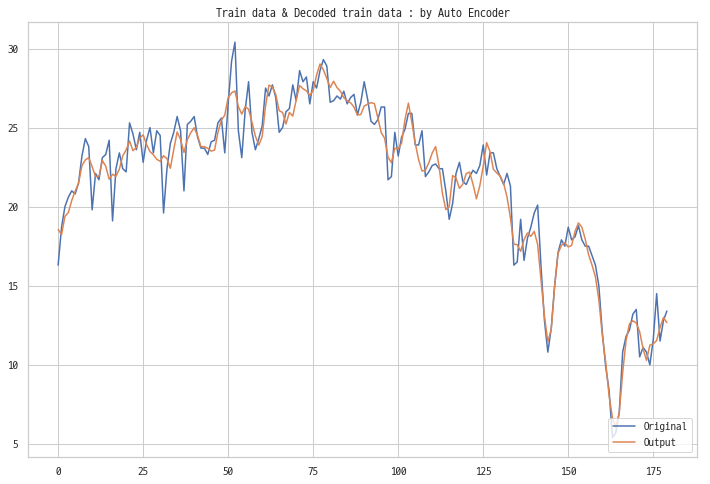

In [22]:
plt.figure(figsize=(12, 8))
plt.title('Train data & Decoded train data : by Auto Encoder')
plt.plot(original_train.data[0].numpy(), label='Original')
plt.plot(output.data[0].numpy(), label='Output')
plt.legend(loc='lower right')
plt.show()

주황색의 output 데이터가 원형 데이터를 잘 따라가고 있음을 확인할 수 있다.

---

## \#6. Apply to `Test data`

#### `test data` 에 생성된 모델을 적용해서 prediction을 구해보자.

### 6-1. Decompose `test_X`

- 먼저 window_size인 180개씩으로 쪼개진 `test_X`를 생성한다.

In [23]:
test_X = list()

test_X.append(raw_test_X[:180])
test_X.append(raw_test_X[180:360])
test_X.append(raw_test_X[360:540])
test_X.append(raw_test_X[540:720])

test_X = np.array(test_X, dtype='float32')

In [24]:
print(pd.DataFrame(test_X).shape)
pd.DataFrame(test_X)

(4, 180)


,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,2.7,5.000000,2.000000,3.900000,3.800000,5.4,4.6,6.5,1.5,-3.700000,...,26.000000,25.4,25.299999,26.700001,24.5,23.799999,23.100000,25.200001,26.0,26.200001
1,25.9,25.299999,24.299999,24.700001,26.700001,27.4,27.6,26.4,26.0,26.299999,...,-6.700000,-1.6,-3.900000,-3.900000,-0.9,3.400000,6.100000,2.900000,-2.1,-3.800000
2,-6.9,-2.100000,2.100000,1.400000,-0.300000,-1.3,-1.8,-4.7,-4.7,-3.000000,...,21.700001,22.5,22.799999,24.799999,22.4,22.700001,23.700001,25.000000,24.5,25.200001
3,27.1,22.299999,22.299999,23.299999,24.700001,24.4,21.9,22.6,27.4,27.299999,...,-1.900000,-2.2,-4.400000,-2.400000,0.0,1.600000,2.600000,4.000000,3.4,5.600000


- 한 row 당 180개의 데이터로, 4개로 쪼개졌음을 알 수 있다.

### 6-2. Apply Model to `test data`

#### test data를 생성되어있는 model에 적용시켜서 복호화 해보자.

In [28]:
original_test = Variable(torch.from_numpy(test_X))
output = model(original_test)

### 6-3. Test data Plotting

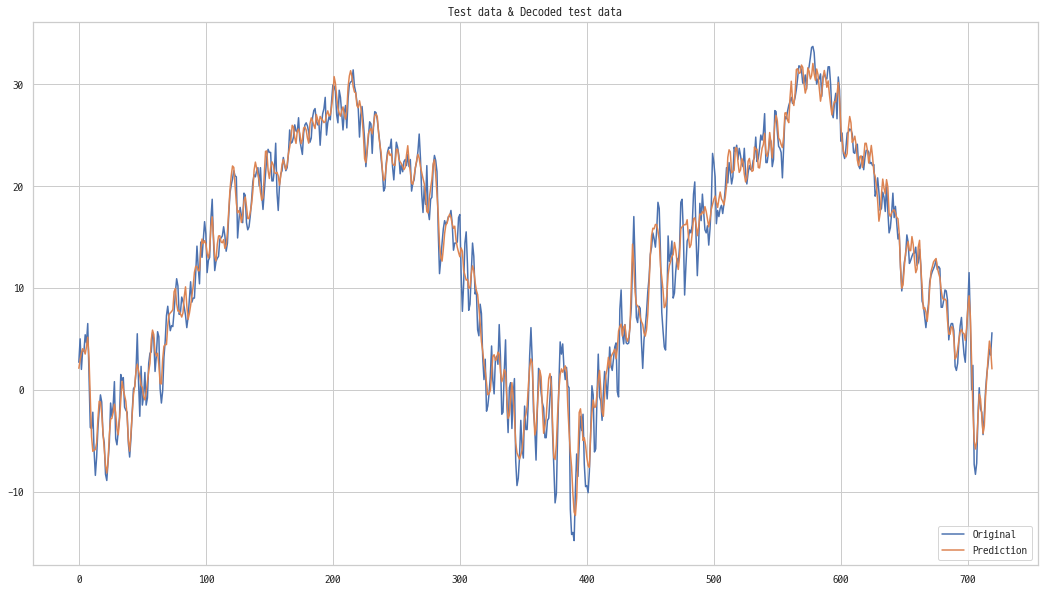

In [29]:
plt.figure(figsize=(18, 10))
plt.title("Test data & Decoded test data")
plt.plot(test_X.flatten(), label='Original')
plt.plot(output.data.numpy().flatten(), label='Prediction')
plt.legend(loc='lower right')
plt.show()

- `Original` 데이터와 `Prediction` 데이터가 유사한 파형으로 그려졌음을 확인

---

## \#7. Anomaly Detection

#### 이제 predict 된 데이터와 원형 test 데이터를 이용해서 이상 기온을 탐지 할 수 있다.

### 7-1. Anomaly Detection Score

- 이상 기온 점수는 원래 기온과의 차이에 제곱을 한 값 (`squared_error`)을 이용한다.

In [32]:
test = test_X.flatten()
pred = output.data.numpy().flatten()

total_score = []

for i in range(len(test)):
    squared_error = (test[i] - pred[i]) ** 2
    total_score.append(squared_error)

- total_score의 최대값으로 나누어 정규화한다.

In [35]:
total_score = np.array(total_score)
max_score = np.max(total_score)
total_score = total_score / max_score

# 이상점수 총 합
sum(total_score)

45.561851892552724

### 7-2. Plotting Error

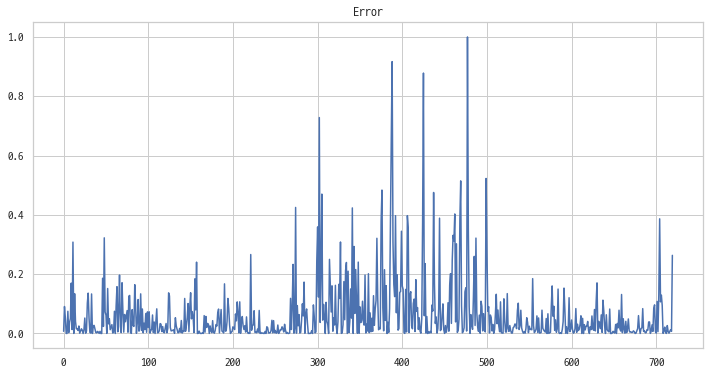

In [37]:
plt.figure(figsize=(12, 6))
plt.title('Error')
plt.plot(total_score)
plt.show()

- 이렇게 `Error`를 시각화해보면, 특히 이상한 기온들을 검출해낼 수 있다.


- 여기서 임계값(`threshold`)을 설정해놓으면 임계값보다 error가 큰 경우를 이상기온이라고 말할 수 있다.